In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np  
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Input, Cropping2D, Flatten
from keras.models import Model
from tensorflow import keras
import tensorflow as tfds
import os
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-oz5g138s
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-oz5g138s
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a80e61f279e77d22ac24a7888e1f24b4933014e0_-py3-none-any.whl size=299719 sha256=ad09a1a0e1830df3810852d983d65ae5c35a670ca7c95cf930fd491cee3359de
  Stored in directory: /tmp/pip-ephem-wheel-cache-043wv_cg/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask
  

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.02745098, 0.01176471, 0.01213235],
         [0.00824621, 0.00824621, 0.00459559],
         [0.00884842, 0.00308862, 0.00596852],
         ...,
         [0.01385474, 0.01740866, 0.0156317 ],
         [0.0214815 , 0.01618605, 0.01246458],
         [0.01960784, 0.01273648, 0.01374272]],
 
        [[0.01200023, 0.01200023, 0.01481886],
         [0.00795324, 0.00795324, 0.00101294],
         [0.00665882, 0.00274395, 0.00377891],
         ...,
         [0.01582893, 0.01213905, 0.01398399],
         [0.01438323, 0.01438323, 0.01539618],
         [0.01471546, 0.01599265, 0.01032954]],
 
        [[0.01783088, 0.00998775, 0.01966912],
         [0.01545458, 0.01176471, 0.01152631],
         [0.00707816, 0.00707816, 0.00707816],
         ...,
         [0.01387963, 0.01963944, 0.0146762 ],
         [0.01331667, 0.01331667, 0.01331667],
         [0.01036209, 0.01726122, 0.01381166]],
 
        ...,
 
        [[0.02071078, 0.02359069

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CHANNELS = 3


In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

1/1 [==============================] - 1s 1s/step


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.02745098, 0.01176471, 0.01213235],
         [0.00824621, 0.00824621, 0.00459559],
         [0.00884842, 0.00308862, 0.00596852],
         ...,
         [0.01385474, 0.01740866, 0.0156317 ],
         [0.0214815 , 0.01618605, 0.01246458],
         [0.01960784, 0.01273648, 0.01374272]],
 
        [[0.01200023, 0.01200023, 0.01481886],
         [0.00795324, 0.00795324, 0.00101294],
         [0.00665882, 0.00274395, 0.00377891],
         ...,
         [0.01582893, 0.01213905, 0.01398399],
         [0.01438323, 0.01438323, 0.01539618],
         [0.01471546, 0.01599265, 0.01032954]],
 
        [[0.01783088, 0.00998775, 0.01966912],
         [0.01545458, 0.01176471, 0.01152631],
         [0.00707816, 0.00707816, 0.00707816],
         ...,
         [0.01387963, 0.01963944, 0.0146762 ],
         [0.01331667, 0.01331667, 0.01331667],
         [0.01036209, 0.01726122, 0.01381166]],
 
        ...,
 
        [[0.02071078, 0.02359069

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 2
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

1/1 [==============================] - 0s 62ms/step


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.02745098, 0.01176471, 0.01213235],
         [0.00824621, 0.00824621, 0.00459559],
         [0.00884842, 0.00308862, 0.00596852],
         ...,
         [0.01385474, 0.01740866, 0.0156317 ],
         [0.0214815 , 0.01618605, 0.01246458],
         [0.01960784, 0.01273648, 0.01374272]],
 
        [[0.01200023, 0.01200023, 0.01481886],
         [0.00795324, 0.00795324, 0.00101294],
         [0.00665882, 0.00274395, 0.00377891],
         ...,
         [0.01582893, 0.01213905, 0.01398399],
         [0.01438323, 0.01438323, 0.01539618],
         [0.01471546, 0.01599265, 0.01032954]],
 
        [[0.01783088, 0.00998775, 0.01966912],
         [0.01545458, 0.01176471, 0.01152631],
         [0.00707816, 0.00707816, 0.00707816],
         ...,
         [0.01387963, 0.01963944, 0.0146762 ],
         [0.01331667, 0.01331667, 0.01331667],
         [0.01036209, 0.01726122, 0.01381166]],
 
        ...,
 
        [[0.02071078, 0.02359069


Sample Prediction after epoch 2

57/57 [==============================] - 293s 5s/step - loss: 0.2998 - accuracy: 0.8772 - val_loss: 0.3062 - val_accuracy: 0.8804


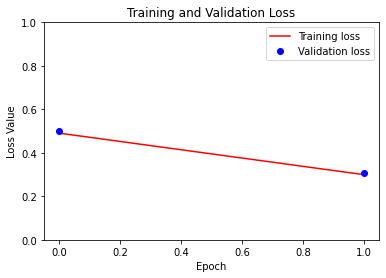

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_dataset, 3)

2/2 [==============================] - 3s 1s/step


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.9764706 , 0.9417586 , 0.9061734 ],
         [0.9832974 , 0.9558464 , 0.9244739 ],
         [0.9855304 , 0.9567605 , 0.9247286 ],
         ...,
         [0.9946232 , 0.958318  , 0.91764706],
         [0.98910844, 0.9546875 , 0.91764706],
         [0.99215686, 0.9529412 , 0.9137255 ]],
 
        [[0.98271054, 0.9479985 , 0.91241336],
         [0.97764176, 0.9501908 , 0.91881824],
         [0.7034146 , 0.6778282 , 0.6493662 ],
         ...,
         [0.99228156, 0.9559764 , 0.91037285],
         [0.99215686, 0.9607843 , 0.91764706],
         [0.99356616, 0.9543505 , 0.9151348 ]],
 
        [[0.9801784 , 0.95272744, 0.9213549 ],
         [0.98512346, 0.94982934, 0.92237836],
         [0.985769  , 0.9554075 , 0.9254902 ],
         ...,
         [0.98862183, 0.95826036, 0.9204999 ],
         [0.99192494, 0.9566308 , 0.9213367 ],
         [0.99607843, 0.95686275, 0.91764706]],
 
        ...,
 
        [[0.28583914, 0.4387882 

2/2 [==============================] - 3s 2s/step


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.20106465, 0.34830728, 0.16557139],
         [0.16705729, 0.31331953, 0.11503524],
         [0.16286765, 0.28769147, 0.09894302],
         ...,
         [0.1895144 , 0.294784  , 0.1251302 ],
         [0.17512254, 0.26028645, 0.10801164],
         [0.14489889, 0.21697304, 0.07369792]],
 
        [[0.22892922, 0.41182598, 0.23801318],
         [0.1903416 , 0.35951287, 0.1820006 ],
         [0.1436734 , 0.28268996, 0.12180606],
         ...,
         [0.25914523, 0.3622549 , 0.14705117],
         [0.21397059, 0.30306372, 0.11370251],
         [0.16342677, 0.23303463, 0.07764246]],
 
        [[0.24993873, 0.4397748 , 0.2741881 ],
         [0.242716  , 0.43052235, 0.26386335],
         [0.22090992, 0.40648744, 0.22228095],
         ...,
         [0.30488664, 0.4396446 , 0.16936274],
         [0.25372243, 0.36158854, 0.1304228 ],
         [0.19869025, 0.2835248 , 0.09918811]],
 
        ...,
 
        [[0.78039217, 0.90232074

2/2 [==============================] - 3s 1s/step


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], 